# 📌 Project Title: Plant Disease Classifier Using Transfer Learning

# 🧠 Overview:
# This notebook builds a deep learning model to classify plant leaf diseases using the PlantVillage dataset.
# It leverages MobileNetV2 via transfer learning for efficient training and high accuracy.
# The final model can be deployed in mobile apps to assist farmers in diagnosing crop diseases.

# 🔧 Tools:
# - TensorFlow/Keras
# - Google Colab (GPU)
# - Python Libraries: NumPy, Pandas, Matplotlib

📂 Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


📦 Step 2: Extract Dataset


In [2]:


import zipfile
import os

# Full path to your file in My Drive
zip_path = "/content/drive/My Drive/PlantVillage.zip"

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/plantvillage")
    print("✅ Extracted successfully!")
else:
    print("❌ File not found — check the path or filename exactly")

✅ Extracted successfully!


🧪 Step 4: Import Libraries

In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


 Step 5: Load and Preprocess Dataset

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 16511 files for training.
classfound ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


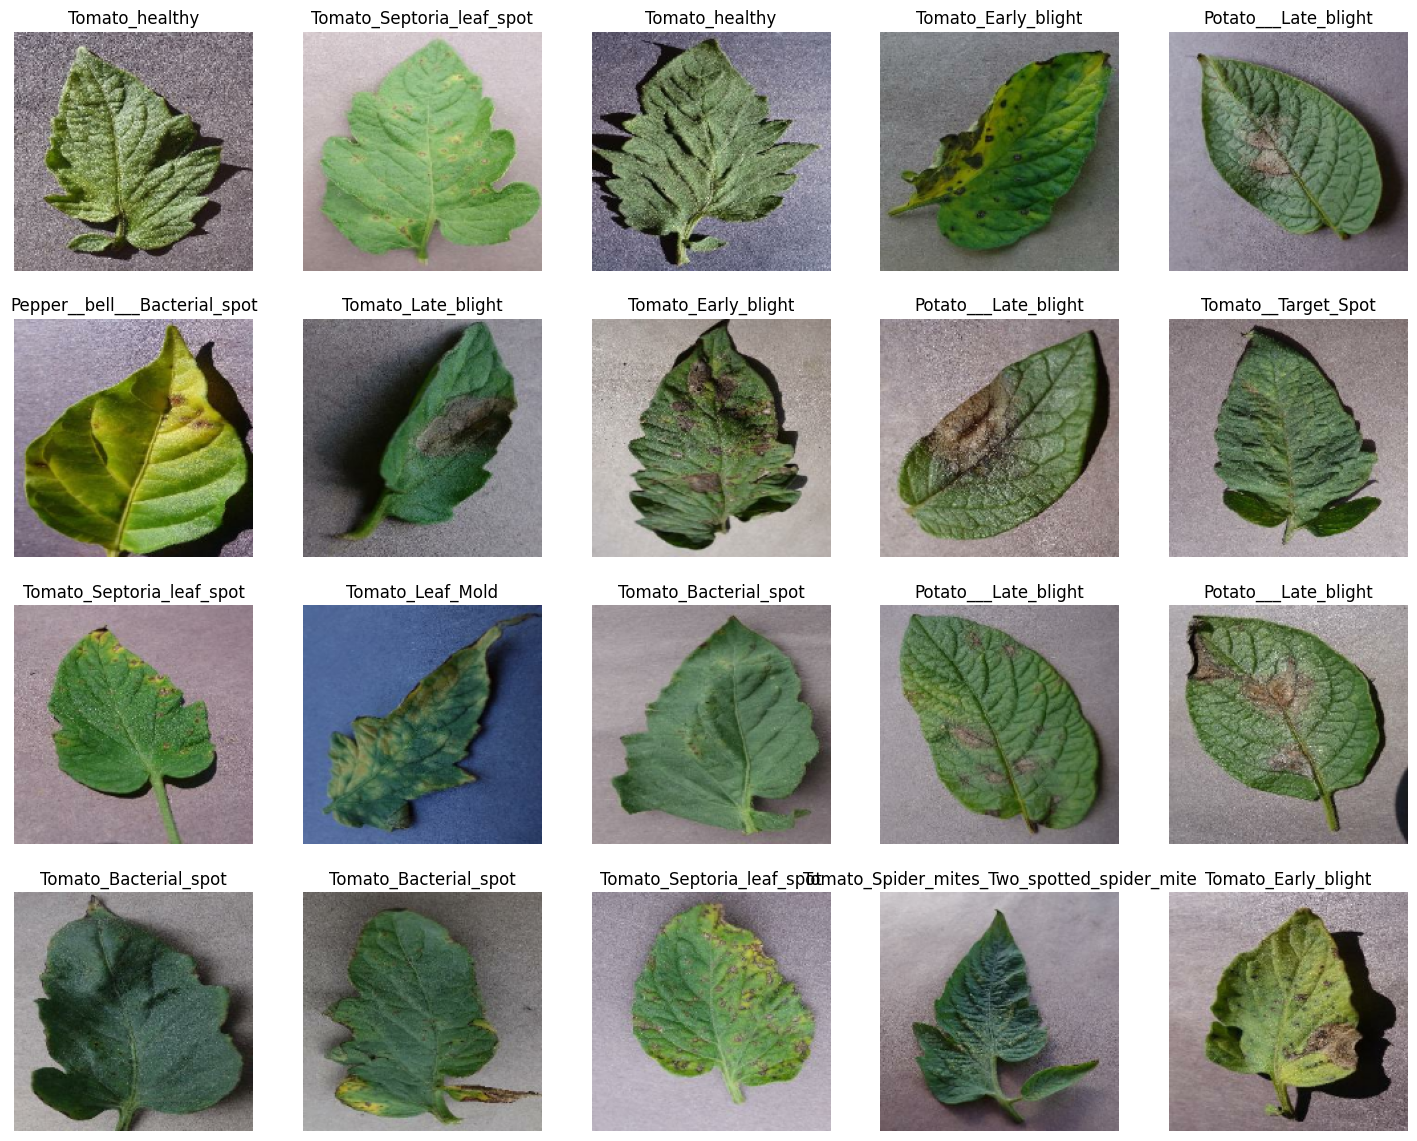

In [4]:
data_path = "/content/plantvillage/PlantVillage/PlantVillage"

image_size = (180, 180)
batch_size = 32
train_dataset = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
classname=train_dataset.class_names
print("classfound",classname)
plt.figure(figsize=(18, 18))
for images, labels in train_dataset.take(1):
    for i in range(20):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classname[labels[i]])
        plt.axis("off")
plt.show()


splitting a validation dataset into validation and test subsets.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

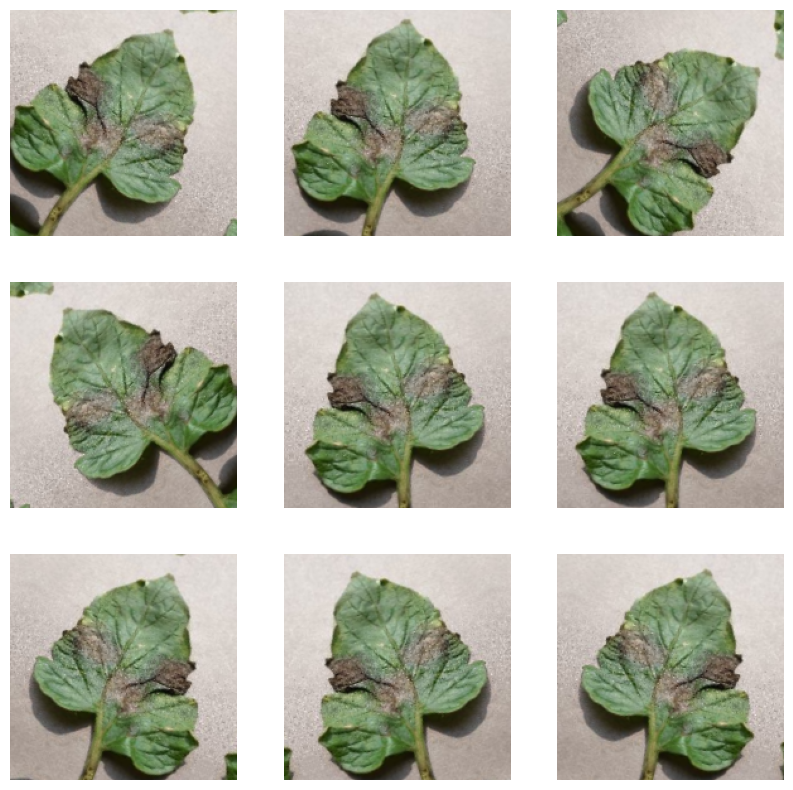

In [8]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

feature extraction using a pretrained model.

In [9]:
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("Feature shape:", feature_batch.shape)


/tmp/ipython-input-56537699.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Feature shape: (32, 6, 6, 1280)


In [10]:
base_model.trainable=False
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

GlobalAveragePooling2D() takes the 4D feature map output from the convolutional base (shape: [batch_size, height, width, channels]).

It averages each channel’s values across the entire spatial dimensions (height and width), reducing each channel’s 2D feature map to a single number.

The result is a 2D tensor with shape [batch_size, channels], a compact, fixed-length feature vector per image.

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
num_classes = 15

prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 15)


 defining the full end-to-end model

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

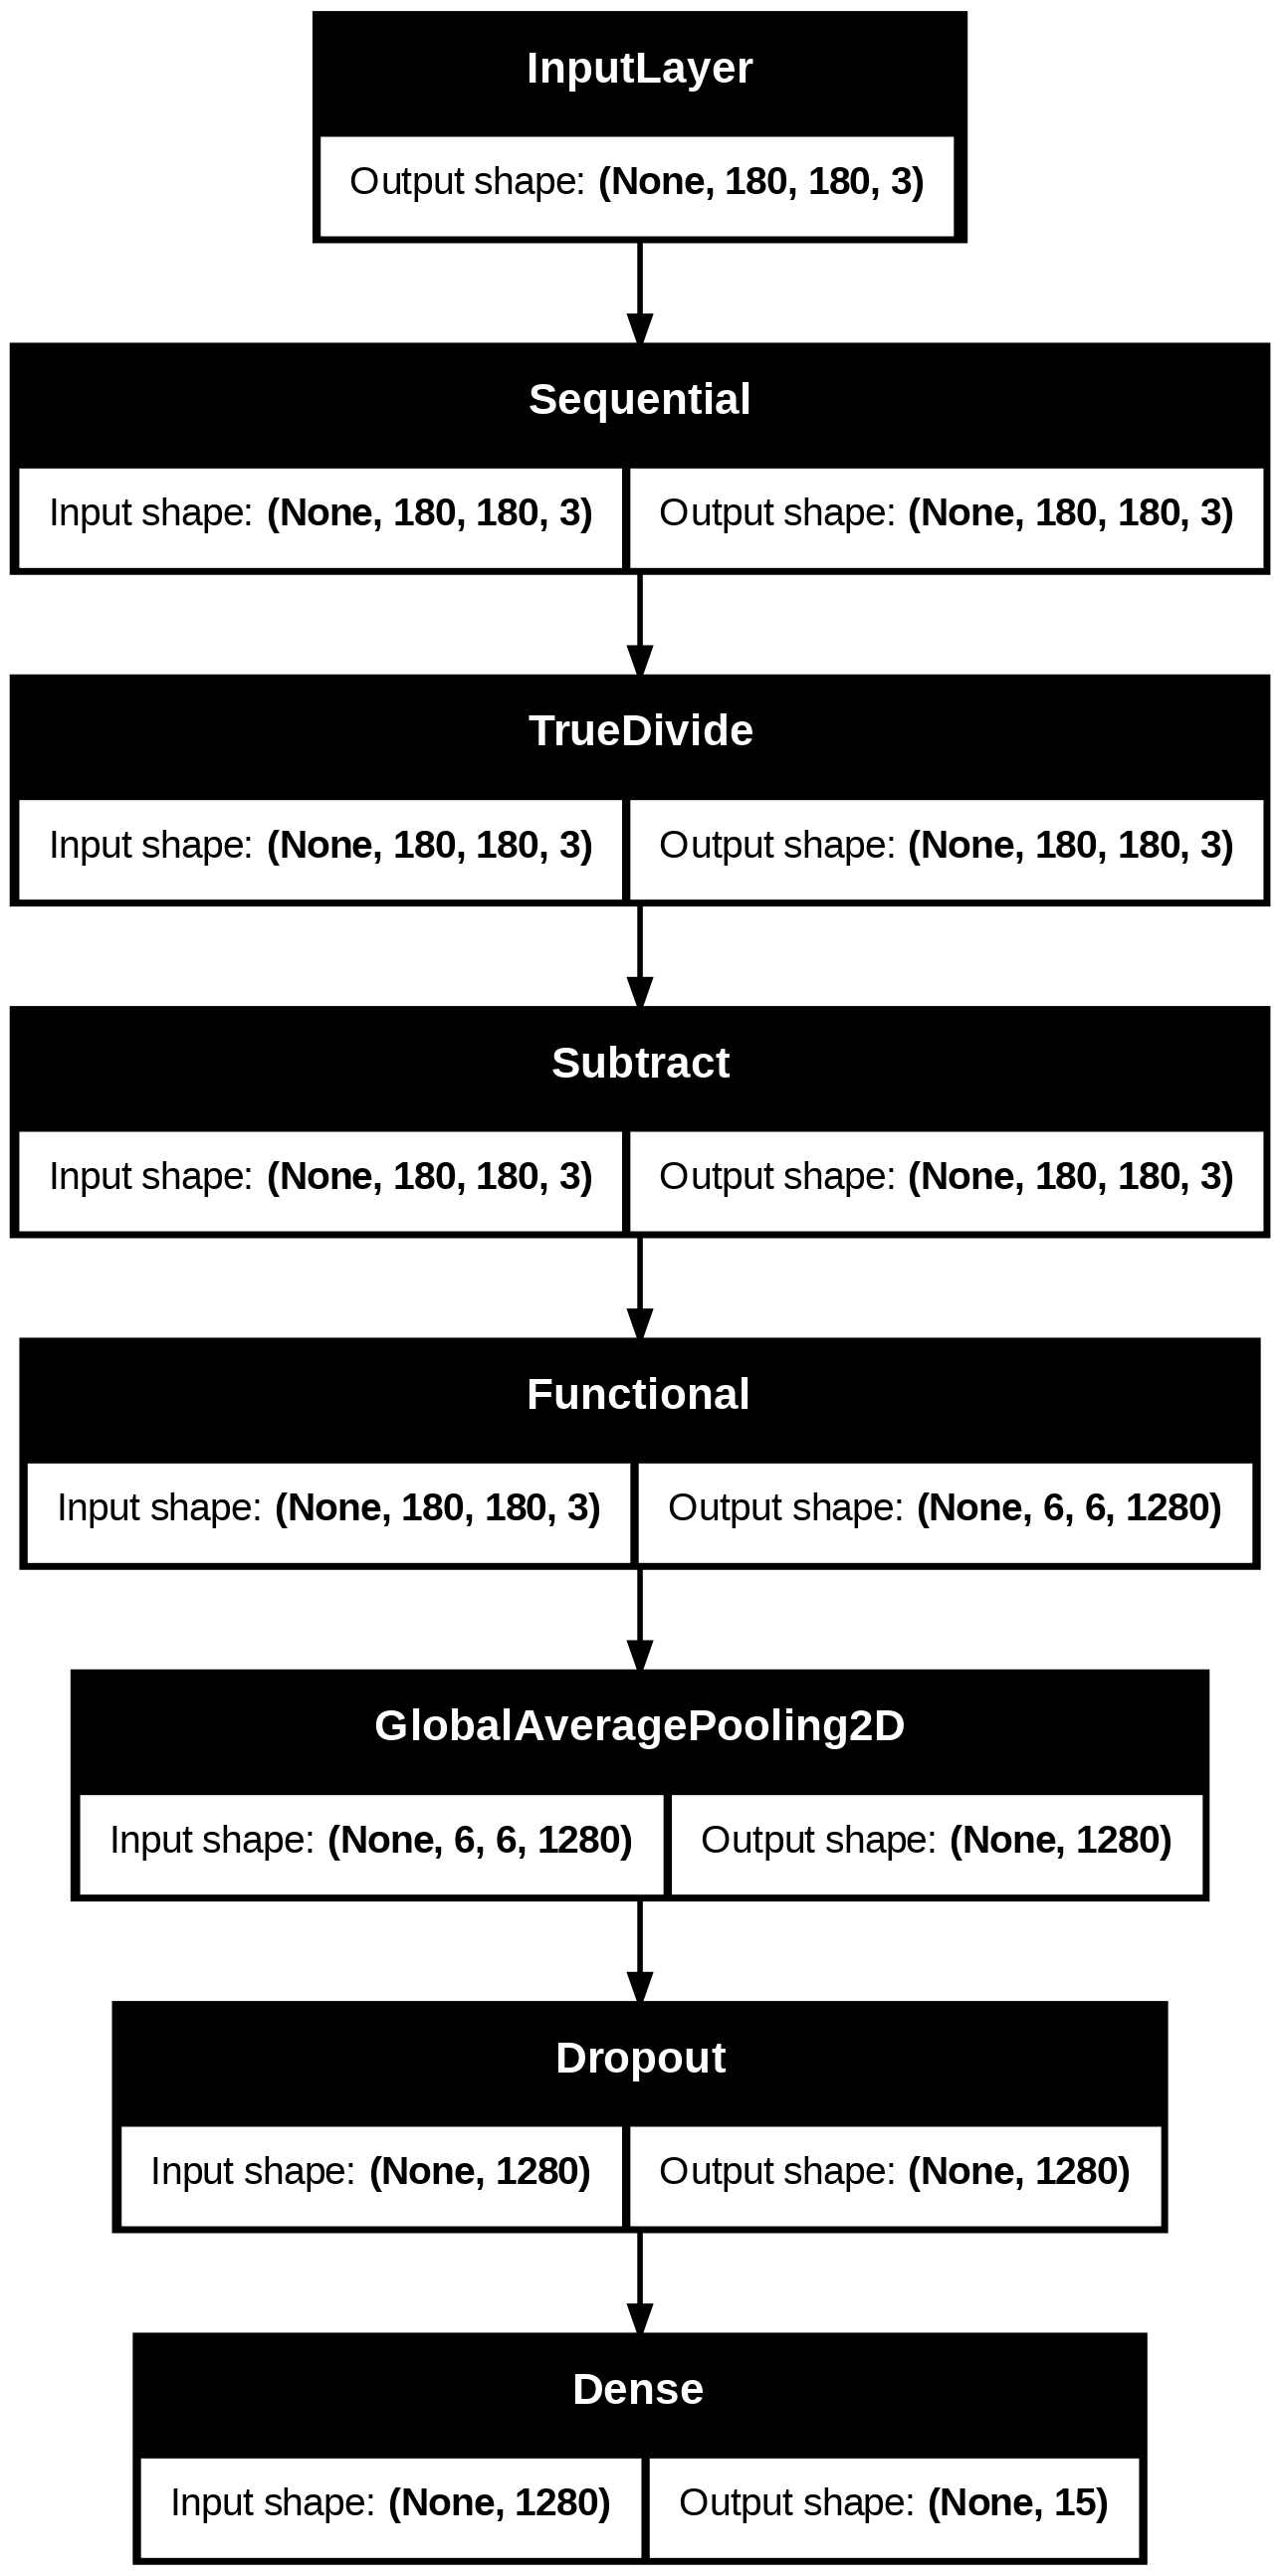

In [15]:
from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, show_shapes=True)

compile

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

413/413 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.0429 - loss: 3.5862


train the model

In [18]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 45s 77ms/step - accuracy: 0.2411 - loss: 2.5169 - val_accuracy: 0.6505 - val_loss: 1.2337
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.6145 - loss: 1.2476 - val_accuracy: 0.7421 - val_loss: 0.8870
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.7035 - loss: 0.9506 - val_accuracy: 0.7848 - val_loss: 0.7351
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.7440 - loss: 0.8173 - val_accuracy: 0.8092 - val_loss: 0.6482
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 80s 77ms/step - accuracy: 0.7729 - loss: 0.7204 - val_accuracy: 0.8254 - val_loss: 0.5891
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.7918 - loss: 0.6586 - val_accuracy: 0.8387 - val_loss: 0.5473
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.8158 - loss: 0.6035 - val_accuracy: 0.8463 - val_loss: 0.5166
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.8184 - loss: 0.5731 - 

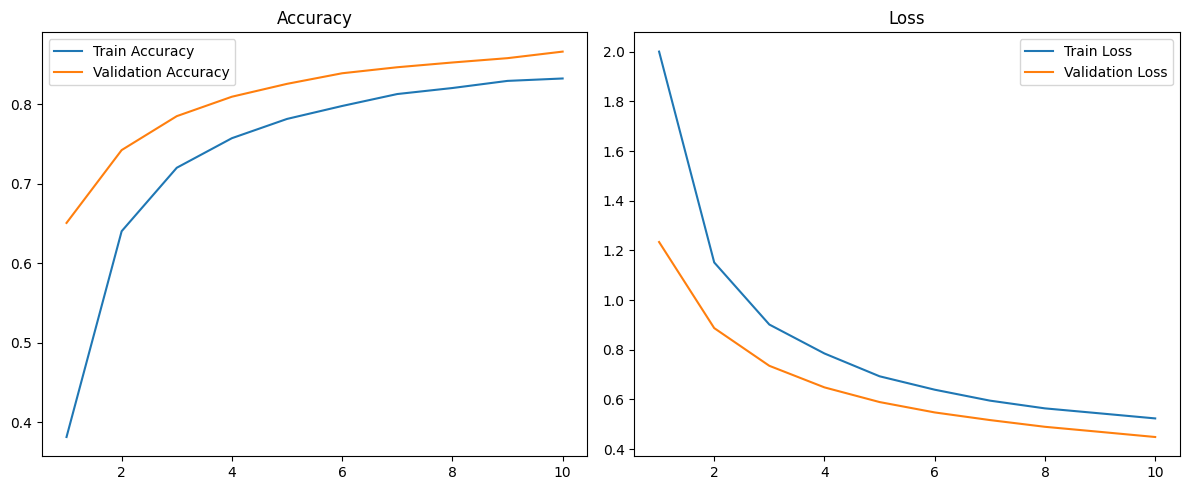

In [19]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

FINE TUNing

In [20]:

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # small LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(train_dataset, validation_data=validation_dataset, epochs=5)

Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 151s 234ms/step - accuracy: 0.6015 - loss: 1.3579 - val_accuracy: 0.8525 - val_loss: 0.4461
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 117s 227ms/step - accuracy: 0.8482 - loss: 0.4628 - val_accuracy: 0.8465 - val_loss: 0.4447
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 145s 234ms/step - accuracy: 0.8927 - loss: 0.3279 - val_accuracy: 0.8649 - val_loss: 0.3872
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.9128 - loss: 0.2641 - val_accuracy: 0.8927 - val_loss: 0.3053
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 143s 232ms/step - accuracy: 0.9278 - loss: 0.2190 - val_accuracy: 0.9059 - val_loss: 0.2689


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


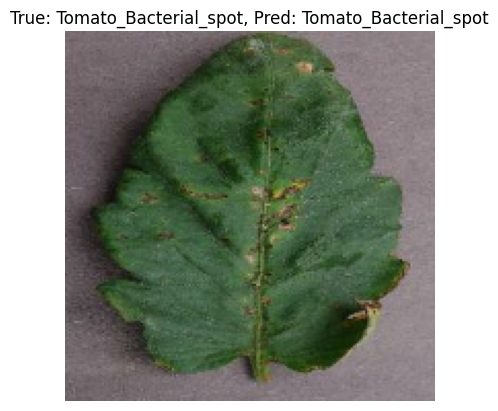

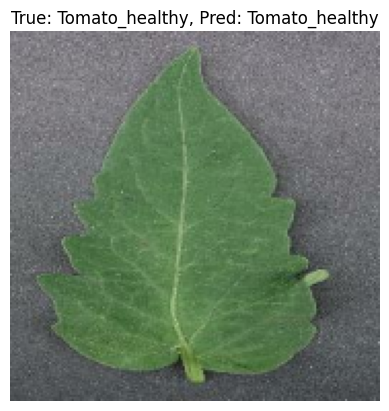

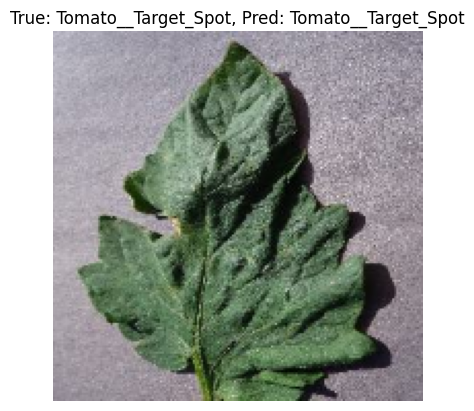

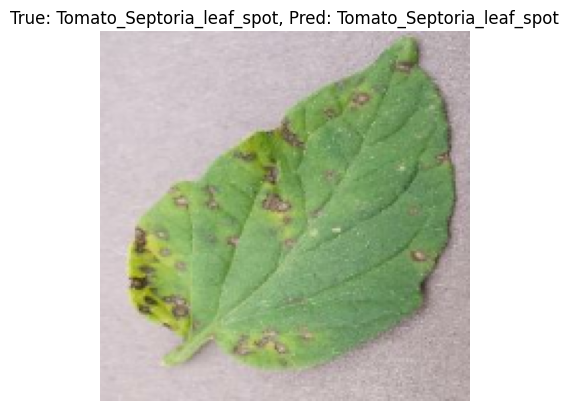

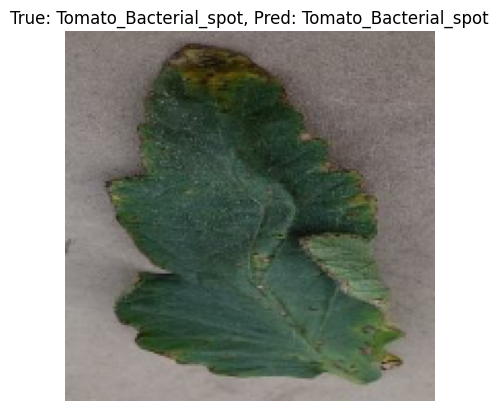

In [21]:
for images, labels in validation_dataset.take(1):
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=1).numpy()
    true_classes = labels.numpy()

    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {classname[true_classes[i]]}, Pred: {classname[pred_classes[i]]}")
        plt.axis('off')
        plt.show()
